In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing


import torch
import torch.utils.data as data_torch
import torch.nn.functional as F
import torch.nn as nn

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda')

In [ ]:
import pickle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/price_dataset/train_data.csv', delimiter=",")

In [ ]:
df_train.head()

In [ ]:
df_train.isnull().any().any()

In [ ]:
df_train["HeatingType"].replace({item : index for index,item in enumerate(df_train.HeatingType.unique().tolist())}, inplace=True)
df_train["HallwayType"].replace({item : index for index,item in enumerate(df_train.HallwayType.unique().tolist())}, inplace=True)
df_train["AptManageType"].replace({item : index for index,item in enumerate(df_train.AptManageType.unique().tolist())}, inplace=True)
df_train["TimeToBusStop"].replace({item : index for index,item in enumerate(df_train.TimeToBusStop.unique().tolist())}, inplace=True)
df_train["TimeToSubway"].replace({item : index for index,item in enumerate(df_train.TimeToSubway.unique().tolist())}, inplace=True)
df_train["SubwayStation"].replace({item : index for index,item in enumerate(df_train.SubwayStation.unique().tolist())}, inplace=True)

In [ ]:
df_train.head()

In [ ]:
df_train.shape

In [ ]:
plt.figure(figsize= (16,16))
sns.heatmap(df_train.corr(), color="k", annot=True)

In [ ]:
plt.figure(figsize=(15,20))
for i, col in enumerate(list(df_train.columns.values)):
    plt.subplot(5,4,i+1)
    df_train.boxplot(col)
    plt.grid()
    plt.tight_layout()

In [ ]:
plt.figure(figsize=(20,16))
for i, col in enumerate(list(df_train.columns.values)):
    plt.subplot(5,4,i+1)
    sns.histplot(df_train[col], color='r', kde=True, stat="density", linewidth=0, label='data')
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()

In [ ]:
sns.pairplot(data=df_train, kind='scatter', diag_kind='kde')

In [ ]:
LR = 2e-2
EPOCHS = 200
DROPOUT = 0.1
BATCH_SIZE = 128

In [ ]:
class MyRegression(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.rel1 = nn.ReLU()
        self.dropout1 = nn.Dropout(DROPOUT)
        self.linear2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.rel2 = nn.ReLU()
        self.dropout2 = nn.Dropout(DROPOUT)
        self.linear3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.rel3 = nn.ReLU()
        self.dropout3 = nn.Dropout(DROPOUT)
        self.linear4 = nn.Linear(32, 1)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                
    def forward(self, x):
        x = self.routine(self.linear1,self.bn1, self.rel1, self.dropout1, x)
        x = self.routine(self.linear2,self.bn2, self.rel2, self.dropout2, x)
        x = self.routine(self.linear3,self.bn3, self.rel3, self.dropout3, x)
        x = self.linear4(x)
        return x
  
    def routine(self, linear_layer, batch_norm, activation, dropout, x):
        x = linear_layer(x)
        x = batch_norm(x)
        x = activation(x)
        x = dropout(x)
        return x

In [ ]:
model = MyRegression(16, 1)
model = model.float()
model.to(device)

In [ ]:
X, y = df_train.values[:,1:], df_train.values[:,0]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train_ts = torch.FloatTensor(X_train)
X_val_ts = torch.FloatTensor(X_val)

y_train_ts = torch.LongTensor(y_train)
y_val_ts = torch.LongTensor(y_val)


train_data = data_torch.TensorDataset(X_train_ts, y_train_ts)
test_data = data_torch.TensorDataset(X_val_ts, y_val_ts)

train_loader = data_torch.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data_torch.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
loss_module = nn.L1Loss()

In [ ]:
# learning loop
model.train()
loss_list = []
for epoch in range(EPOCHS):
  for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)
      outputs = model(x)
      loss = loss_module(outputs.squeeze(dim=1).float(), y.float())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  
  loss_list.append(loss.item())
  if epoch % 10 == 0:
    print(f"Epoch: {epoch}, loss={loss.item():.3}")

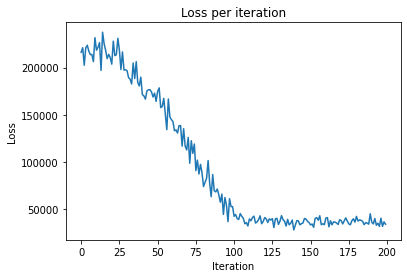

In [ ]:
plt.plot(loss_list)
plt.title("Loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
import csv

In [ ]:
model.eval()
MSE = 0
gather = []
with torch.no_grad():
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)
        preds = model(data.float()).squeeze()
        pred_label = torch.cat((label.reshape(-1,1),preds.reshape(-1,1)), 1)
        gather.append(pred_label.cpu().numpy())
        MSE += ((torch.pow((preds - label), 2)).sum()) / len(label)

to_csv = np.concatenate(gather)
p_error = np.abs(to_csv[:, 0] - to_csv[:, 1]) / to_csv[:, 0] * 100
to_csv = np.column_stack((to_csv, p_error))
with open('nn_valid_pred.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Label", "Prediction", "Error"])
    writer.writerows(to_csv)

print(f"MSE: {MSE / len(test_loader)}")



MSE: 2013155072.0


In [ ]:
sns.histplot(p_error)

#XGboost

In [ ]:
import xgboost as xgb

In [ ]:
xgbc = xgb.XGBRegressor()

In [ ]:
xgbc.fit(X_train,y_train)

[17:23:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [ ]:
preds = xgbc.predict(X_val)

In [ ]:
print(f"MSE: {((np.power((preds - y_val), 2)).sum()) / len(y_val)}")

In [ ]:
to_csv = np.concatenate((y_val.reshape(-1,1), preds.reshape(-1,1)), 1)
p_error = np.abs(to_csv[:, 0] - to_csv[:, 1]) / to_csv[:, 0] * 100
to_csv = np.column_stack((to_csv, p_error))

with open('xgboost_valid_pred.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["Label", "Prediction", "Error"])
    writer.writerows(to_csv)

In [ ]:
sns.histplot(p_error)